In [1]:
from dask.distributed import Client

client = Client(n_workers=4)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 1.94 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35317,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 1.94 GiB
Comm: tcp://10.0.5.2:43583,Total threads: 1
Dashboard: http://10.0.5.2:44955/status,Memory: 496.43 MiB
Nanny: tcp://127.0.0.1:42567,


In [2]:
client.close()

In [3]:
import time

def add(x, y=1):
    time.sleep(1)
    return x + y

In [4]:
%%time

for _ in range(2):
    print(add(10))

result = add(10, 10)
result

11
11
CPU times: user 7.77 ms, sys: 7.74 ms, total: 15.5 ms
Wall time: 3.01 s


20

In [5]:
from dask import delayed

In [6]:
%%time

for _ in range(2):
    print(delayed(add)(10))

result = delayed(add)(10, 10)
result

Delayed('add-d93fcc2a-1741-44e4-ac3b-ac754df016e6')
Delayed('add-f8a7626c-ba3b-4d48-abd7-039b413fb2a1')
CPU times: user 830 µs, sys: 4.39 ms, total: 5.22 ms
Wall time: 4.3 ms


Delayed('add-b8183ae8-2dd5-4cdf-a3a1-b09f77818089')

In [7]:
%%time

result.compute()

CPU times: user 3.35 ms, sys: 3.55 ms, total: 6.9 ms
Wall time: 1.01 s


20

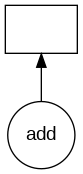

In [8]:
result.visualize()